In [18]:
import sys 
sys.path.append('../../')

%load_ext autoreload
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, Grayscale
from torchvision.datasets import MNIST, CIFAR10 
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit

%autoreload 2
from networks import *
from utils import *
from losses import *
from landscape import *
from datasets import *

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Training Setup

In [19]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)


# Set training static parameters and hyperparameters
nepochs=100
dims_latent = 32                            
learning_rate=1e-3
batch_size=16                                        
device=set_device("cuda", 0)
train_size=0.00108/64

# Losses
l2loss    = nn.MSELoss(reduction="sum")
awi1D     = AWLoss1DFFT(reduction="sum", std=3e-4, store_filters="norm", epsilon=3e-15)
awi2D     = AWLoss2DFFT(reduction="sum", std=3e-4, store_filters="norm", epsilon=3e-15)


No GPU available! Running on CPU


## Datasets and Dataloaders

In [20]:
# Train Transforms
train_transform = Compose([
    Resize(28),
    Grayscale(),
])

# Datasets and dataloaders
ds = CIFAR10("../data", download=True, train=True, transform=train_transform)

try:
    shuffler = StratifiedShuffleSplit(n_splits=1, test_size=1-train_size, random_state=42).split(ds.data, ds.targets)
    train_idx, valid_idx = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]
except:
    train_idx=[7]

X_train, y_train = torch.from_numpy(ds.data[train_idx]) / 255., torch.tensor(ds.targets)[train_idx]
X_train = X_train.permute(0, 3, 1, 2)
trainds = TransformTensorDataset(X_train.float(), y_train.float(), transform=train_transform)

train_loader = DataLoader(trainds, batch_size=batch_size, shuffle=True, num_workers=4)

X = trainds[0][0].unsqueeze(0).to(device) # a sample for check ups
print("Trainable Images:", len(trainds))
print(X.shape, X.min().item(), X.max().item())

Files already downloaded and verified
Trainable Images: 1
torch.Size([1, 1, 28, 28]) 0.08018966019153595 0.8850318193435669


## Autoencoder (CNN)

In [21]:
def model_instance():
    return CAE28(dims_latent=dims_latent, nc=X.shape[1]).to(device)

model_sample = model_instance()

print(model_sample)
print(X.shape, model_sample(X).shape)

CAE28(
  (activation): Mish()
  (sigmoid): Sigmoid()
  (e_cv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2))
  (e_cv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (e_cv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
  (e_fc5): Linear(in_features=128, out_features=32, bias=True)
  (d_fc1): Linear(in_features=32, out_features=128, bias=True)
  (d_cv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(3, 3))
  (d_cv3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(3, 3))
  (d_cv4): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(3, 3))
)
torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


## Training MSE Loss



Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--



 {'epoch': 0, 'loss': 41.4605712890625, 'mse (validation)': 0.052702389657497406, 'kl_loss': 0.0}


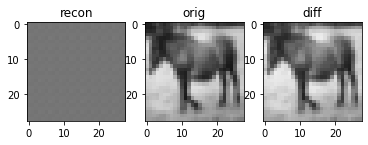

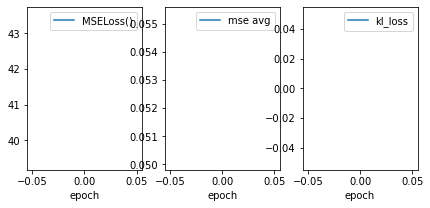

  1% (1 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:01:01
  2% (2 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:41
  3% (3 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:00:34
  4% (4 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:00:31
  5% (5 of 100) |#                       | Elapsed Time: 0:00:01 ETA:   0:00:29
  6% (6 of 100) |#                       | Elapsed Time: 0:00:01 ETA:   0:00:27
  7% (7 of 100) |#                       | Elapsed Time: 0:00:01 ETA:   0:00:26
  8% (8 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:25
  9% (9 of 100) |##                      | Elapsed Time: 0:00:02 ETA:   0:00:24
 10% (10 of 100) |##                     | Elapsed Time: 0:00:02 ETA:   0:00:20
 11% (11 of 100) |##                     | Elapsed Time: 0:00:02 ETA:   0:00:20
 12% (12 of 100) |##                     | Elapsed Time: 0:00:03 ETA:   0:00:20
 13% (13 of 100) |##                    


 {'epoch': 20, 'loss': 10.105900764465332, 'mse (validation)': 0.011644448153674603, 'kl_loss': 0.0}


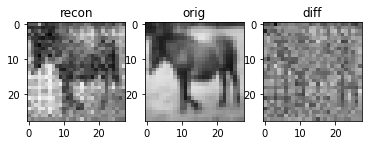

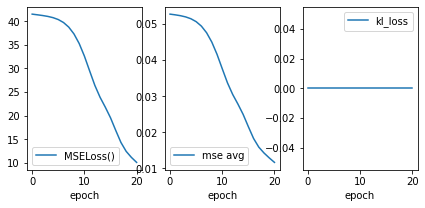

 21% (21 of 100) |####                   | Elapsed Time: 0:00:05 ETA:   0:00:23
 22% (22 of 100) |#####                  | Elapsed Time: 0:00:05 ETA:   0:00:23
 23% (23 of 100) |#####                  | Elapsed Time: 0:00:06 ETA:   0:00:23
 24% (24 of 100) |#####                  | Elapsed Time: 0:00:06 ETA:   0:00:23
 25% (25 of 100) |#####                  | Elapsed Time: 0:00:06 ETA:   0:00:23
 26% (26 of 100) |#####                  | Elapsed Time: 0:00:06 ETA:   0:00:22
 27% (27 of 100) |######                 | Elapsed Time: 0:00:07 ETA:   0:00:22
 28% (28 of 100) |######                 | Elapsed Time: 0:00:07 ETA:   0:00:21
 29% (29 of 100) |######                 | Elapsed Time: 0:00:07 ETA:   0:00:20
 30% (30 of 100) |######                 | Elapsed Time: 0:00:07 ETA:   0:00:17
 31% (31 of 100) |#######                | Elapsed Time: 0:00:08 ETA:   0:00:16
 32% (32 of 100) |#######                | Elapsed Time: 0:00:08 ETA:   0:00:16
 33% (33 of 100) |#######               


 {'epoch': 40, 'loss': 1.3927838802337646, 'mse (validation)': 0.0016383703332394361, 'kl_loss': 0.0}


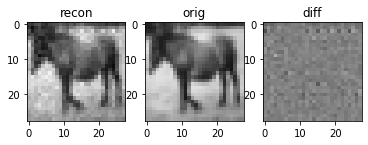

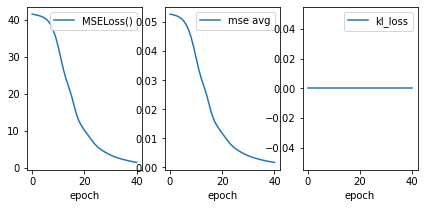

 41% (41 of 100) |#########              | Elapsed Time: 0:00:10 ETA:   0:00:17
 42% (42 of 100) |#########              | Elapsed Time: 0:00:11 ETA:   0:00:17
 43% (43 of 100) |#########              | Elapsed Time: 0:00:11 ETA:   0:00:16
 44% (44 of 100) |##########             | Elapsed Time: 0:00:11 ETA:   0:00:16
 45% (45 of 100) |##########             | Elapsed Time: 0:00:11 ETA:   0:00:16
 46% (46 of 100) |##########             | Elapsed Time: 0:00:12 ETA:   0:00:15
 47% (47 of 100) |##########             | Elapsed Time: 0:00:12 ETA:   0:00:15
 48% (48 of 100) |###########            | Elapsed Time: 0:00:12 ETA:   0:00:14
 49% (49 of 100) |###########            | Elapsed Time: 0:00:12 ETA:   0:00:14
 50% (50 of 100) |###########            | Elapsed Time: 0:00:13 ETA:   0:00:11
 51% (51 of 100) |###########            | Elapsed Time: 0:00:13 ETA:   0:00:11
 52% (52 of 100) |###########            | Elapsed Time: 0:00:13 ETA:   0:00:11
 53% (53 of 100) |############          


 {'epoch': 60, 'loss': 0.28691086173057556, 'mse (validation)': 0.0003391446953173727, 'kl_loss': 0.0}


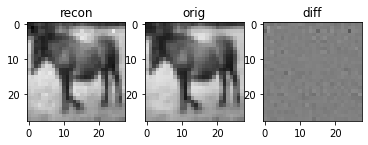

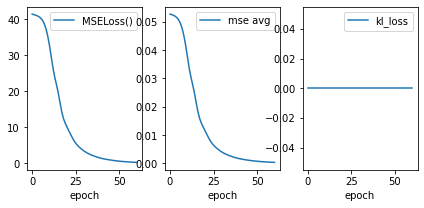

 61% (61 of 100) |##############         | Elapsed Time: 0:00:16 ETA:   0:00:11
 62% (62 of 100) |##############         | Elapsed Time: 0:00:16 ETA:   0:00:11
 63% (63 of 100) |##############         | Elapsed Time: 0:00:16 ETA:   0:00:10
 64% (64 of 100) |##############         | Elapsed Time: 0:00:16 ETA:   0:00:10
 65% (65 of 100) |##############         | Elapsed Time: 0:00:17 ETA:   0:00:10
 66% (66 of 100) |###############        | Elapsed Time: 0:00:17 ETA:   0:00:10
 67% (67 of 100) |###############        | Elapsed Time: 0:00:17 ETA:   0:00:09
 68% (68 of 100) |###############        | Elapsed Time: 0:00:17 ETA:   0:00:09
 69% (69 of 100) |###############        | Elapsed Time: 0:00:17 ETA:   0:00:08
 70% (70 of 100) |################       | Elapsed Time: 0:00:18 ETA:   0:00:07
 71% (71 of 100) |################       | Elapsed Time: 0:00:18 ETA:   0:00:06
 72% (72 of 100) |################       | Elapsed Time: 0:00:18 ETA:   0:00:06
 73% (73 of 100) |################      


 {'epoch': 80, 'loss': 0.06201539188623428, 'mse (validation)': 7.370136881945655e-05, 'kl_loss': 0.0}


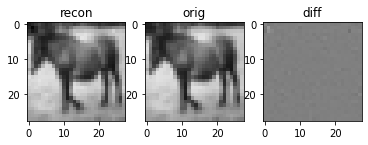

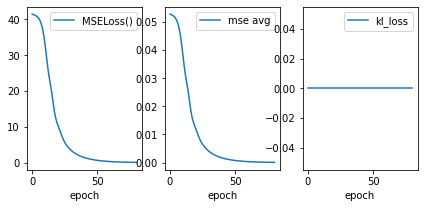

 81% (81 of 100) |##################     | Elapsed Time: 0:00:21 ETA:   0:00:05
 82% (82 of 100) |##################     | Elapsed Time: 0:00:21 ETA:   0:00:05
 83% (83 of 100) |###################    | Elapsed Time: 0:00:21 ETA:   0:00:05
 84% (84 of 100) |###################    | Elapsed Time: 0:00:21 ETA:   0:00:04
 85% (85 of 100) |###################    | Elapsed Time: 0:00:22 ETA:   0:00:04
 86% (86 of 100) |###################    | Elapsed Time: 0:00:22 ETA:   0:00:04
 87% (87 of 100) |####################   | Elapsed Time: 0:00:22 ETA:   0:00:03
 88% (88 of 100) |####################   | Elapsed Time: 0:00:22 ETA:   0:00:03
 89% (89 of 100) |####################   | Elapsed Time: 0:00:23 ETA:   0:00:03
 90% (90 of 100) |####################   | Elapsed Time: 0:00:23 ETA:   0:00:02
 91% (91 of 100) |####################   | Elapsed Time: 0:00:23 ETA:   0:00:02
 92% (92 of 100) |#####################  | Elapsed Time: 0:00:23 ETA:   0:00:01
 93% (93 of 100) |##################### 


 {'epoch': 99, 'loss': 0.020375443622469902, 'mse (validation)': 2.4906155886128545e-05, 'kl_loss': 0.0}


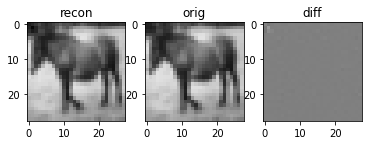

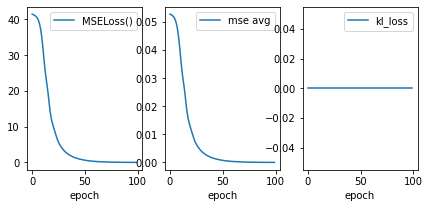

100% (100 of 100) |######################| Elapsed Time: 0:00:25 Time:  0:00:25


In [22]:
model = model_instance()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, optimizer, train_loader, l2loss, nepochs, log_frequency=20, sample=X, device=device, gradflow=False)

### Loss Landscape

In [23]:
# train_subset = Subset(trainds, list(np.random.randint(0, len(trainds), size=16)))
# train_subloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
# print("Train Subset len: ", len(train_subset))
# xx, yy, loss_landscape = visualise_landscape(model, train_subloader, awi1D, device=device)

## Training AWLoss1D



Training started ...


N/A% (0 of 2500) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--



 {'epoch': 0, 'loss': 0.631231427192688, 'mse (validation)': 0.05546388775110245, 'kl_loss': 0.0}
 argidx T, v:  783 783


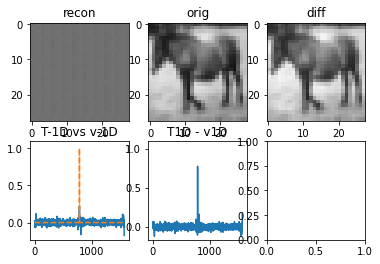

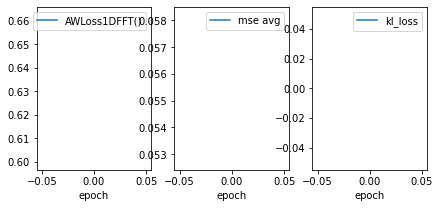

  0% (1 of 2500) |                       | Elapsed Time: 0:00:00 ETA:   0:35:50
  0% (2 of 2500) |                       | Elapsed Time: 0:00:01 ETA:   0:23:02
  0% (3 of 2500) |                       | Elapsed Time: 0:00:01 ETA:   0:18:57
  0% (4 of 2500) |                       | Elapsed Time: 0:00:01 ETA:   0:16:48
  0% (5 of 2500) |                       | Elapsed Time: 0:00:01 ETA:   0:15:33
  0% (6 of 2500) |                       | Elapsed Time: 0:00:02 ETA:   0:14:42
  0% (7 of 2500) |                       | Elapsed Time: 0:00:02 ETA:   0:14:10
  0% (8 of 2500) |                       | Elapsed Time: 0:00:02 ETA:   0:13:45
  0% (9 of 2500) |                       | Elapsed Time: 0:00:02 ETA:   0:10:35
  0% (10 of 2500) |                      | Elapsed Time: 0:00:03 ETA:   0:10:29
  0% (11 of 2500) |                      | Elapsed Time: 0:00:03 ETA:   0:10:23
  0% (12 of 2500) |                      | Elapsed Time: 0:00:03 ETA:   0:10:22
  0% (13 of 2500) |                     


 {'epoch': 500, 'loss': 0.09897982329130173, 'mse (validation)': 0.02779252454638481, 'kl_loss': 0.0}
 argidx T, v:  783 783


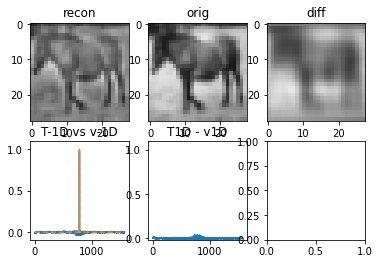

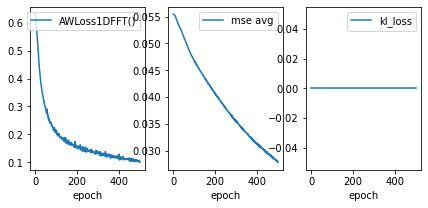

 20% (501 of 2500) |####                 | Elapsed Time: 0:02:05 ETA:   0:11:24
 20% (502 of 2500) |####                 | Elapsed Time: 0:02:05 ETA:   0:11:20
 20% (503 of 2500) |####                 | Elapsed Time: 0:02:05 ETA:   0:11:21
 20% (504 of 2500) |####                 | Elapsed Time: 0:02:05 ETA:   0:11:21
 20% (505 of 2500) |####                 | Elapsed Time: 0:02:05 ETA:   0:11:12
 20% (506 of 2500) |####                 | Elapsed Time: 0:02:06 ETA:   0:11:05
 20% (507 of 2500) |####                 | Elapsed Time: 0:02:06 ETA:   0:10:44
 20% (508 of 2500) |####                 | Elapsed Time: 0:02:06 ETA:   0:10:23
 20% (509 of 2500) |####                 | Elapsed Time: 0:02:06 ETA:   0:10:05
 20% (510 of 2500) |####                 | Elapsed Time: 0:02:07 ETA:   0:08:08
 20% (511 of 2500) |####                 | Elapsed Time: 0:02:07 ETA:   0:08:07
 20% (512 of 2500) |####                 | Elapsed Time: 0:02:07 ETA:   0:08:05
 20% (513 of 2500) |####                


 {'epoch': 1000, 'loss': 0.06934905797243118, 'mse (validation)': 0.01811707206070423, 'kl_loss': 0.0}
 argidx T, v:  783 783


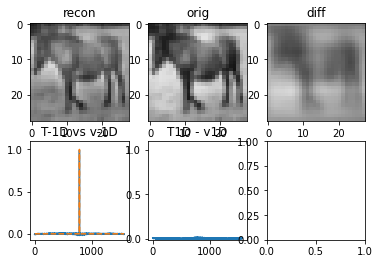

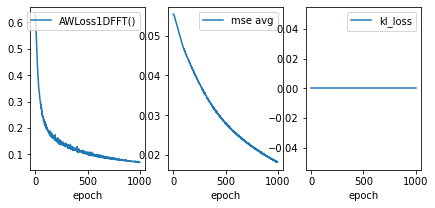

 40% (1001 of 2500) |########            | Elapsed Time: 0:04:08 ETA:   0:07:53
 40% (1002 of 2500) |########            | Elapsed Time: 0:04:09 ETA:   0:07:48
 40% (1003 of 2500) |########            | Elapsed Time: 0:04:09 ETA:   0:07:48
 40% (1004 of 2500) |########            | Elapsed Time: 0:04:09 ETA:   0:07:46
 40% (1005 of 2500) |########            | Elapsed Time: 0:04:09 ETA:   0:07:50
 40% (1006 of 2500) |########            | Elapsed Time: 0:04:10 ETA:   0:07:52
 40% (1007 of 2500) |########            | Elapsed Time: 0:04:10 ETA:   0:07:49
 40% (1008 of 2500) |########            | Elapsed Time: 0:04:10 ETA:   0:07:34
 40% (1009 of 2500) |########            | Elapsed Time: 0:04:10 ETA:   0:07:22
 40% (1010 of 2500) |########            | Elapsed Time: 0:04:11 ETA:   0:05:53
 40% (1011 of 2500) |########            | Elapsed Time: 0:04:11 ETA:   0:05:50
 40% (1012 of 2500) |########            | Elapsed Time: 0:04:11 ETA:   0:05:50
 40% (1013 of 2500) |########           


 {'epoch': 1500, 'loss': 0.05403119698166847, 'mse (validation)': 0.012506058439612389, 'kl_loss': 0.0}
 argidx T, v:  783 783


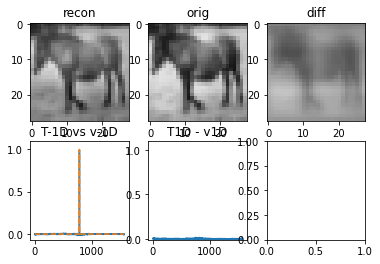

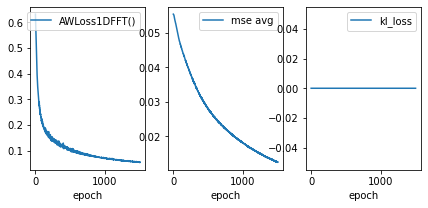

 60% (1501 of 2500) |############        | Elapsed Time: 0:06:12 ETA:   0:05:38
 60% (1502 of 2500) |############        | Elapsed Time: 0:06:12 ETA:   0:05:38
 60% (1503 of 2500) |############        | Elapsed Time: 0:06:12 ETA:   0:05:39
 60% (1504 of 2500) |############        | Elapsed Time: 0:06:13 ETA:   0:05:40
 60% (1505 of 2500) |############        | Elapsed Time: 0:06:13 ETA:   0:05:40
 60% (1506 of 2500) |############        | Elapsed Time: 0:06:13 ETA:   0:05:40
 60% (1507 of 2500) |############        | Elapsed Time: 0:06:13 ETA:   0:05:27
 60% (1508 of 2500) |############        | Elapsed Time: 0:06:14 ETA:   0:05:18
 60% (1509 of 2500) |############        | Elapsed Time: 0:06:14 ETA:   0:05:08
 60% (1510 of 2500) |############        | Elapsed Time: 0:06:14 ETA:   0:04:01
 60% (1511 of 2500) |############        | Elapsed Time: 0:06:14 ETA:   0:04:03
 60% (1512 of 2500) |############        | Elapsed Time: 0:06:14 ETA:   0:04:03
 60% (1513 of 2500) |############       


 {'epoch': 2000, 'loss': 0.04513302817940712, 'mse (validation)': 0.009179727174341679, 'kl_loss': 0.0}
 argidx T, v:  783 783


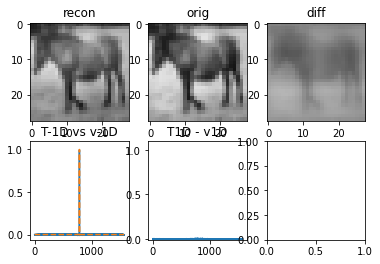

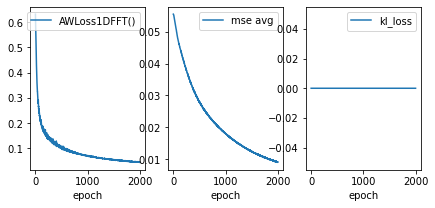

 80% (2001 of 2500) |################    | Elapsed Time: 0:08:16 ETA:   0:02:49
 80% (2002 of 2500) |################    | Elapsed Time: 0:08:16 ETA:   0:02:47
 80% (2003 of 2500) |################    | Elapsed Time: 0:08:17 ETA:   0:02:46
 80% (2004 of 2500) |################    | Elapsed Time: 0:08:17 ETA:   0:02:46
 80% (2005 of 2500) |################    | Elapsed Time: 0:08:17 ETA:   0:02:45
 80% (2006 of 2500) |################    | Elapsed Time: 0:08:17 ETA:   0:02:44
 80% (2007 of 2500) |################    | Elapsed Time: 0:08:17 ETA:   0:02:37
 80% (2008 of 2500) |################    | Elapsed Time: 0:08:18 ETA:   0:02:33
 80% (2009 of 2500) |################    | Elapsed Time: 0:08:18 ETA:   0:02:28
 80% (2010 of 2500) |################    | Elapsed Time: 0:08:18 ETA:   0:01:58
 80% (2011 of 2500) |################    | Elapsed Time: 0:08:18 ETA:   0:01:57
 80% (2012 of 2500) |################    | Elapsed Time: 0:08:19 ETA:   0:01:56
 80% (2013 of 2500) |################   


 {'epoch': 2499, 'loss': 0.038668692111968994, 'mse (validation)': 0.007076255511492491, 'kl_loss': 0.0}
 argidx T, v:  783 783


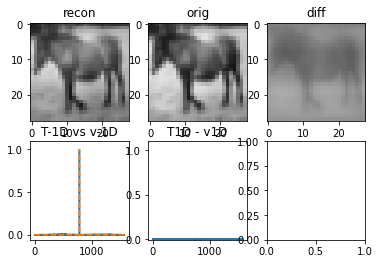

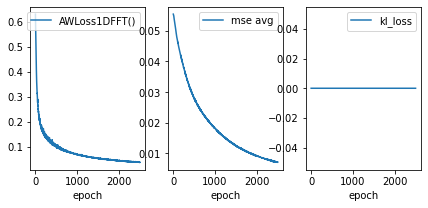

100% (2500 of 2500) |####################| Elapsed Time: 0:10:18 Time:  0:10:18


In [28]:
model = model_instance()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, optimizer, train_loader, awi1D, nepochs*25, log_frequency=20*25, sample=X, device=device, gradflow=False)

### Loss Landscape

In [25]:
# train_subset = Subset(trainds, list(np.random.randint(0, len(trainds), size=16)))
# train_subloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
# print("Train Subset len: ", len(train_subset))
# xx, yy, loss_landscape = visualise_landscape(model, train_subloader, awi1D, device=device)

## Training AWLoss2D



Training started ...


N/A% (0 of 2500) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--



 {'epoch': 0, 'loss': 0.6477312445640564, 'mse (validation)': 0.05156394839286804, 'kl_loss': 0.0}
 argidx T, v:  1512 1512


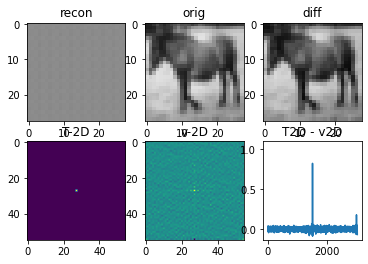

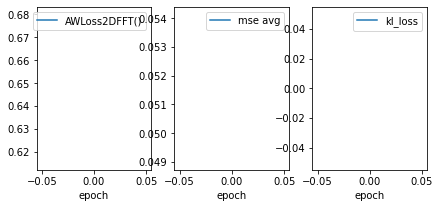

  0% (1 of 2500) |                       | Elapsed Time: 0:00:00 ETA:   0:33:54
  0% (2 of 2500) |                       | Elapsed Time: 0:00:01 ETA:   0:22:10
  0% (3 of 2500) |                       | Elapsed Time: 0:00:01 ETA:   0:18:14
  0% (4 of 2500) |                       | Elapsed Time: 0:00:01 ETA:   0:16:18
  0% (5 of 2500) |                       | Elapsed Time: 0:00:01 ETA:   0:15:14
  0% (6 of 2500) |                       | Elapsed Time: 0:00:02 ETA:   0:14:27
  0% (7 of 2500) |                       | Elapsed Time: 0:00:02 ETA:   0:13:46
  0% (8 of 2500) |                       | Elapsed Time: 0:00:02 ETA:   0:13:16
  0% (9 of 2500) |                       | Elapsed Time: 0:00:02 ETA:   0:12:58
  0% (10 of 2500) |                      | Elapsed Time: 0:00:03 ETA:   0:10:19
  0% (11 of 2500) |                      | Elapsed Time: 0:00:03 ETA:   0:10:18
  0% (12 of 2500) |                      | Elapsed Time: 0:00:03 ETA:   0:10:26
  0% (13 of 2500) |                     


 {'epoch': 500, 'loss': 0.11070938408374786, 'mse (validation)': 0.02756975218653679, 'kl_loss': 0.0}
 argidx T, v:  1512 1512


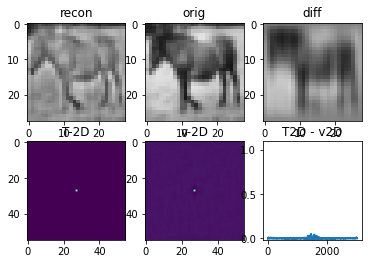

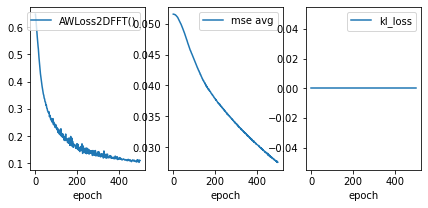

 20% (501 of 2500) |####                 | Elapsed Time: 0:02:07 ETA:   0:11:44
 20% (502 of 2500) |####                 | Elapsed Time: 0:02:08 ETA:   0:11:41
 20% (503 of 2500) |####                 | Elapsed Time: 0:02:08 ETA:   0:11:32
 20% (504 of 2500) |####                 | Elapsed Time: 0:02:08 ETA:   0:11:21
 20% (505 of 2500) |####                 | Elapsed Time: 0:02:08 ETA:   0:11:09
 20% (506 of 2500) |####                 | Elapsed Time: 0:02:09 ETA:   0:11:06
 20% (507 of 2500) |####                 | Elapsed Time: 0:02:09 ETA:   0:10:40
 20% (508 of 2500) |####                 | Elapsed Time: 0:02:09 ETA:   0:10:21
 20% (509 of 2500) |####                 | Elapsed Time: 0:02:09 ETA:   0:10:08
 20% (510 of 2500) |####                 | Elapsed Time: 0:02:10 ETA:   0:08:08
 20% (511 of 2500) |####                 | Elapsed Time: 0:02:10 ETA:   0:08:06
 20% (512 of 2500) |####                 | Elapsed Time: 0:02:10 ETA:   0:08:05
 20% (513 of 2500) |####                


 {'epoch': 1000, 'loss': 0.0771680548787117, 'mse (validation)': 0.017622221261262894, 'kl_loss': 0.0}
 argidx T, v:  1512 1512


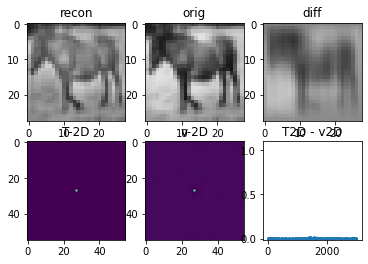

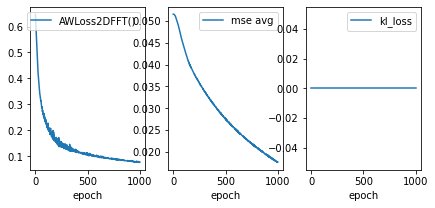

 40% (1001 of 2500) |########            | Elapsed Time: 0:04:15 ETA:   0:08:49
 40% (1002 of 2500) |########            | Elapsed Time: 0:04:15 ETA:   0:08:51
 40% (1003 of 2500) |########            | Elapsed Time: 0:04:15 ETA:   0:08:47
 40% (1004 of 2500) |########            | Elapsed Time: 0:04:16 ETA:   0:08:43
 40% (1005 of 2500) |########            | Elapsed Time: 0:04:16 ETA:   0:08:40
 40% (1006 of 2500) |########            | Elapsed Time: 0:04:16 ETA:   0:08:40
 40% (1007 of 2500) |########            | Elapsed Time: 0:04:16 ETA:   0:08:20
 40% (1008 of 2500) |########            | Elapsed Time: 0:04:17 ETA:   0:08:03
 40% (1009 of 2500) |########            | Elapsed Time: 0:04:17 ETA:   0:06:18
 40% (1010 of 2500) |########            | Elapsed Time: 0:04:17 ETA:   0:06:16
 40% (1011 of 2500) |########            | Elapsed Time: 0:04:17 ETA:   0:06:16
 40% (1012 of 2500) |########            | Elapsed Time: 0:04:18 ETA:   0:06:14
 40% (1013 of 2500) |########           


 {'epoch': 1500, 'loss': 0.058303747326135635, 'mse (validation)': 0.011068224906921387, 'kl_loss': 0.0}
 argidx T, v:  1512 1512


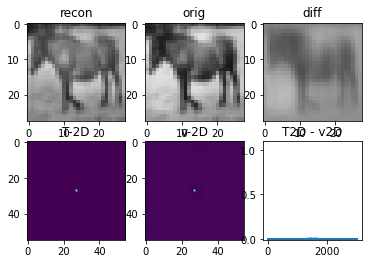

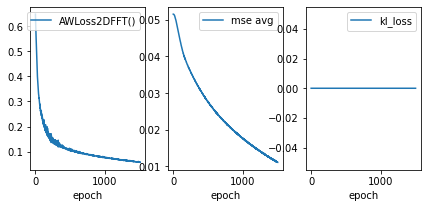

 60% (1501 of 2500) |############        | Elapsed Time: 0:06:23 ETA:   0:05:47
 60% (1502 of 2500) |############        | Elapsed Time: 0:06:23 ETA:   0:05:46
 60% (1503 of 2500) |############        | Elapsed Time: 0:06:23 ETA:   0:05:45
 60% (1504 of 2500) |############        | Elapsed Time: 0:06:23 ETA:   0:05:42
 60% (1505 of 2500) |############        | Elapsed Time: 0:06:24 ETA:   0:05:39
 60% (1506 of 2500) |############        | Elapsed Time: 0:06:24 ETA:   0:05:35
 60% (1507 of 2500) |############        | Elapsed Time: 0:06:24 ETA:   0:05:21
 60% (1508 of 2500) |############        | Elapsed Time: 0:06:24 ETA:   0:05:11
 60% (1509 of 2500) |############        | Elapsed Time: 0:06:24 ETA:   0:05:02
 60% (1510 of 2500) |############        | Elapsed Time: 0:06:25 ETA:   0:04:03
 60% (1511 of 2500) |############        | Elapsed Time: 0:06:25 ETA:   0:04:03
 60% (1512 of 2500) |############        | Elapsed Time: 0:06:25 ETA:   0:04:02
 60% (1513 of 2500) |############       


 {'epoch': 2000, 'loss': 0.04557883366942406, 'mse (validation)': 0.006693126168102026, 'kl_loss': 0.0}
 argidx T, v:  1512 1512


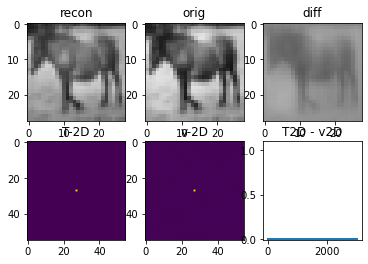

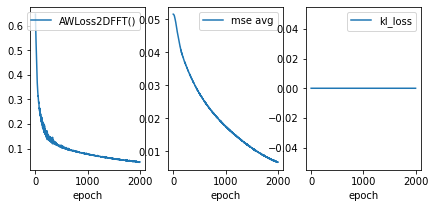

 80% (2001 of 2500) |################    | Elapsed Time: 0:08:29 ETA:   0:03:06
 80% (2002 of 2500) |################    | Elapsed Time: 0:08:29 ETA:   0:03:04
 80% (2003 of 2500) |################    | Elapsed Time: 0:08:29 ETA:   0:03:04
 80% (2004 of 2500) |################    | Elapsed Time: 0:08:29 ETA:   0:03:04
 80% (2005 of 2500) |################    | Elapsed Time: 0:08:30 ETA:   0:03:02
 80% (2006 of 2500) |################    | Elapsed Time: 0:08:30 ETA:   0:03:01
 80% (2007 of 2500) |################    | Elapsed Time: 0:08:30 ETA:   0:02:53
 80% (2008 of 2500) |################    | Elapsed Time: 0:08:30 ETA:   0:02:47
 80% (2009 of 2500) |################    | Elapsed Time: 0:08:31 ETA:   0:02:04
 80% (2010 of 2500) |################    | Elapsed Time: 0:08:31 ETA:   0:02:04
 80% (2011 of 2500) |################    | Elapsed Time: 0:08:31 ETA:   0:02:03
 80% (2012 of 2500) |################    | Elapsed Time: 0:08:31 ETA:   0:02:03
 80% (2013 of 2500) |################   


 {'epoch': 2499, 'loss': 0.035317011177539825, 'mse (validation)': 0.004362952429801226, 'kl_loss': 0.0}
 argidx T, v:  1512 1512


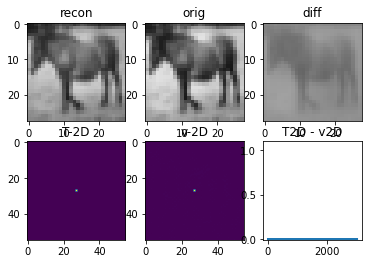

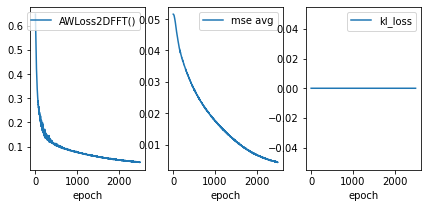

100% (2500 of 2500) |####################| Elapsed Time: 0:10:36 Time:  0:10:36


In [29]:
model = model_instance()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, optimizer, train_loader, awi2D, nepochs*25, log_frequency=20*25, sample=X, device=device, gradflow=False)

### Loss Landscape

In [ ]:
# train_subset = Subset(trainds, list(np.random.randint(0, len(trainds), size=16)))
# train_subloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
# print("Train Subset len: ", len(train_subset))
# xx, yy, loss_landscape = visualise_landscape(model, train_subloader, awi1D, device=device)